In [ ]:
import torch
import torch.nn as nn
import numpy as np
import datetime
import os
import librosa
import pandas as pd
from hear21passt.base import get_basic_model
from torch.utils.data import Dataset, DataLoader
import gc

In [ ]:
MODEL_NAME = 'DANN'
print("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class PaSSTFeatureExtractor(torch.nn.Module):
    def __init__(self, device=None):
        super(PaSSTFeatureExtractor, self).__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = get_basic_model(mode="embed_only") 
        self.model.to(self.device)
        self.model.eval()

    def forward(self, audio_waveform, sample_rate=32000):
        if audio_waveform.dim() == 1:
            audio_waveform = audio_waveform.unsqueeze(0)  

        audio_waveform = audio_waveform.to(self.device)
        
        # Allow gradients to flow through PaSST for domain adaptation
        features = self.model(audio_waveform)
             
        return features

In [ ]:

class Classifier(nn.Module):
    """Simplified Classifier"""
    def __init__(self, input_size=768, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, h):
        return self.layer(h)

In [ ]:
class Discriminator(nn.Module):
    """Simplified Discriminator"""
    def __init__(self, input_size=768):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, h):
        return self.layer(h)

In [1]:
# this is just the audio mapping and loading setup 
class AudioDataset(Dataset):
    def __init__(self, root_dir, csv_file=None, sample_rate=44000, max_length=10):  # if you find trouble woht big audio reduce it by changing max_length
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.max_length = max_length
        self.files = []
        self.labels = []
        self.label_to_idx = {}
        
        # Load labels from CSV if provided
        if csv_file and os.path.exists(csv_file):
            df = pd.read_csv(csv_file, delimiter='\t')
            print(f"CSV columns: {list(df.columns)}")
            
            filename_to_label = {}
            
            # Find label and filename columns
            label_col = None
            filename_col = None
            
            for col in df.columns:
                if 'label' in col.lower() or 'scene' in col.lower() or 'class' in col.lower():
                    label_col = col
                    break
            
            for col in df.columns:
                if 'filename' in col.lower() or 'file' in col.lower() or 'name' in col.lower():
                    filename_col = col
                    break
            
            if label_col is None or filename_col is None:
                if len(df.columns) >= 2:
                    filename_col = df.columns[0]
                    label_col = df.columns[1]
                    print(f"Using columns: filename='{filename_col}', label='{label_col}'")
                else:
                    raise ValueError("CSV file must have at least 2 columns")
            
            # Get unique labels and create mapping
            unique_labels = sorted(df[label_col].unique())
            self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
            self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
            
            # Create filename to label mapping
            existing_files = set(os.listdir(root_dir))
            for _, row in df.iterrows():
                csv_filename = row[filename_col]
                if '/' in csv_filename:
                    csv_filename = csv_filename.split('/')[-1]
                
                if csv_filename in existing_files:
                    filename_to_label[csv_filename] = row[label_col]
            
            print(f"Found {len(filename_to_label)} matching files in {root_dir}")
            
            # Load files and labels
            matched_files = 0
            for fname in sorted(os.listdir(root_dir)):
                if fname.endswith('.wav'):
                    if fname in filename_to_label:
                        self.files.append(os.path.join(root_dir, fname))
                        scene_label = filename_to_label[fname]
                        label_idx = self.label_to_idx[scene_label]
                        self.labels.append(label_idx)
                        matched_files += 1
            
            print(f"Successfully loaded {matched_files} files with labels")
        else:
            for fname in sorted(os.listdir(root_dir)):
                if fname.endswith('.wav'):
                    self.files.append(os.path.join(root_dir, fname))
                    self.labels.append(0)
            
        print(f"Dataset {root_dir}: {len(self.files)} audio files")
        if self.label_to_idx:
            print(f"Label mapping: {self.label_to_idx}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        audio_path = self.files[idx]
        label = self.labels[idx]
        
        
        waveform, sr = librosa.load(audio_path, sr=self.sample_rate, mono=True)
        
        if self.max_length:
            max_samples = int(self.max_length * self.sample_rate)
            if len(waveform) > max_samples:
                waveform = waveform[:max_samples]
        
        waveform = torch.tensor(waveform, dtype=torch.float32)
        return waveform, label
    
    def get_num_classes(self):
        return len(self.label_to_idx) if self.label_to_idx else 1

NameError: name 'Dataset' is not defined

In [ ]:
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:


batch_size = 16  
max_audio_length =10

meta_csv = '/home/teaching/G3/Datasets/archive/final data/meta.csv'

source_train = AudioDataset(
    root_dir='/home/teaching/G3/Datasets/train/source',
    csv_file=meta_csv,
    max_length=max_audio_length
)
target_train = AudioDataset(
    root_dir='/home/teaching/G3/Datasets/train/target',
    csv_file=meta_csv,
    max_length=max_audio_length
)
test_dataset = AudioDataset(
    root_dir='/home/teaching/G3/Datasets/test',
    csv_file=meta_csv,
    max_length=max_audio_length
)

num_classes = max(
    source_train.get_num_classes(), 
    target_train.get_num_classes(),
    test_dataset.get_num_classes()
)

In [ ]:
print(f"Number of classes: {num_classes}")
print(f"Source train samples: {len(source_train)}")
print(f"Target train samples: {len(target_train)}")
print(f"Test samples: {len(test_dataset)}")

In [ ]:
# Data loader
source_loader = DataLoader(source_train, batch_size=batch_size, shuffle=True, 
                          drop_last=True, num_workers=1, pin_memory=False)
target_loader = DataLoader(target_train, batch_size=batch_size, shuffle=True, 
                          drop_last=True, num_workers=1, pin_memory=False)
eval_loader = DataLoader(source_train, batch_size=batch_size, shuffle=False, 
                        drop_last=False, num_workers=1, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                        drop_last=False, num_workers=1, pin_memory=False)


In [ ]:
# Model initialization
F = PaSSTFeatureExtractor().to(DEVICE)  
C = Classifier(num_classes=num_classes).to(DEVICE)
D = Discriminator().to(DEVICE)


In [ ]:
print(f"Feature extractor trainable parameters: {sum(p.numel() for p in F.parameters() if p.requires_grad)}")
print(f"Classifier parameters: {sum(p.numel() for p in C.parameters())}")
print(f"Discriminator parameters: {sum(p.numel() for p in D.parameters())}")

In [ ]:
# Loss functions
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [ ]:


# Optimizer
F_opt = torch.optim.Adam(F.parameters(), lr=1e-5) 
C_opt = torch.optim.Adam(C.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(D.parameters(), lr=1e-3)

In [ ]:
max_epoch = 50  
step = 0


def create_combined_loader():
    
    source_iter = iter(source_loader)
    target_iter = iter(target_loader)
    
    
    min_len = min(len(source_loader), len(target_loader))
    
    for _ in range(min_len):
        try:
            src_data = next(source_iter)
            tgt_data = next(target_iter)
            yield src_data, tgt_data
        except StopIteration:
            break

In [ ]:
def get_lambda(epoch, max_epoch):
    
    p = float(epoch) / float(max_epoch)  
    return 2. / (1. + np.exp(-10. * p)) - 1.

In [ ]:
def evaluate_model(data_loader, name="", max_batches=50):
    
    F.eval()
    C.eval()
    corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for idx, (data, labels) in enumerate(data_loader):
            if idx >= max_batches:  
                break
                
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            
            features = F(data)
            outputs = C(features)
            _, preds = torch.max(outputs, 1)
            
            corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = corrects / total_samples if total_samples > 0 else 0
    print(f'***** {name} Result: {accuracy:.4f} (based on {total_samples} samples)')
    return accuracy

In [1]:

# Training loop
print(f"Starting training for {max_epoch} epochs...")
print("="*60)

clear_memory()


steps_per_epoch = min(len(source_loader), len(target_loader))
print(f"Steps per epoch: {steps_per_epoch}")

for epoch in range(1, max_epoch + 1):
    print(f"\nEpoch {epoch}/{max_epoch}")
    epoch_start_time = datetime.datetime.now()
    
   
    current_lambda = get_lambda(epoch - 1, max_epoch)  
    
    for batch_idx, ((src_images, labels), (tgt_images, _)) in enumerate(create_combined_loader()):
        try:
           
            src = src_images.to(DEVICE)
            labels = labels.to(DEVICE)
            tgt = tgt_images.to(DEVICE)

            
            current_batch_size = src.size(0)
            D_src = torch.ones(current_batch_size, 1).to(DEVICE)
            D_tgt = torch.zeros(current_batch_size, 1).to(DEVICE)
            D_labels = torch.cat([D_src, D_tgt], dim=0)

           
            src_features = F(src)
            tgt_features = F(tgt)
            h = torch.cat([src_features, tgt_features], dim=0)

            
            D.zero_grad()
            y = D(h.detach())
            Ld = bce(y, D_labels)
            Ld.backward()
            D_opt.step()

          
            C.zero_grad()
            F.zero_grad()
            c = C(src_features)
            y = D(h)
            Lc = xe(c, labels)
            Ld_adv = bce(y, D_labels)

           
            Ltot = Lc - current_lambda * Ld_adv
            Ltot.backward()
            C_opt.step()
            F_opt.step()  

            
            if step % 25 == 0:
                dt = datetime.datetime.now().strftime('%H:%M:%S')
                print(f'Epoch: {epoch}/{max_epoch}, Step: {step}, Batch: {batch_idx+1}/{steps_per_epoch}, '
                      f'D Loss: {Ld.item():.4f}, C Loss: {Lc.item():.4f}, '
                      f'lambda: {current_lambda:.4f} ---- {dt}')

            step += 1
            
           
            if step % 50 == 0:
                clear_memory()
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"CUDA out of memory at step {step}. Clearing cache and continuing...")
                clear_memory()
                continue
            else:
                raise e
    
   
    print(f"\nEvaluation after epoch {epoch}:")
    src_acc = evaluate_model(eval_loader, f"Source (Epoch {epoch})")
    tgt_acc = evaluate_model(DataLoader(target_train, batch_size=batch_size, 
                                      shuffle=False, num_workers=1), f"Target (Epoch {epoch})")
    test_acc = evaluate_model(test_loader, f"Test (Epoch {epoch})")
    
  
    if epoch == 1:
        print(f"Baseline accuracies - Source: {src_acc:.4f}, Target: {tgt_acc:.4f}, Test: {test_acc:.4f}")
    else:
        print(f"Current lambda: {current_lambda:.4f}")
        print(f"Domain gap (Target - Source): {tgt_acc - src_acc:.4f}")
    
    
    F.train()
    C.train()
    
    epoch_time = datetime.datetime.now() - epoch_start_time
    print(f"Epoch {epoch} completed in {epoch_time}")
    print("-" * 50)
    
    clear_memory()


print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

final_src_acc = evaluate_model(eval_loader, "Final Source", max_batches=50)
final_tgt_acc = evaluate_model(DataLoader(target_train, batch_size=batch_size, shuffle=False), 
                               "Final Target", max_batches=50)  
final_test_acc = evaluate_model(test_loader, "Final Test", max_batches=50)

print("Training completed!")
print(f"Final test accuracy: {final_test_acc:.4f}")

# Save models
torch.save({
    'classifier': C.state_dict(), 
    'discriminator': D.state_dict(),
    'final_accuracy': final_test_acc
}, f'dann_model_final_acc_{final_test_acc:.4f}.pth')

print("Model saved successfully!")
clear_memory()

cuda
CSV columns: ['filename', 'scene_label', 'identifier', 'source_label']
Found 10215 matching files in /home/teaching/G3/Datasets/train/source
Successfully loaded 10215 files with labels
Dataset /home/teaching/G3/Datasets/train/source: 10215 audio files
Label mapping: {'airport': 0, 'bus': 1, 'metro': 2, 'metro_station': 3, 'park': 4, 'public_square': 5, 'shopping_mall': 6, 'street_pedestrian': 7, 'street_traffic': 8, 'tram': 9}
CSV columns: ['filename', 'scene_label', 'identifier', 'source_label']
Found 3747 matching files in /home/teaching/G3/Datasets/train/target
Successfully loaded 3747 files with labels
Dataset /home/teaching/G3/Datasets/train/target: 3747 audio files
Label mapping: {'airport': 0, 'bus': 1, 'metro': 2, 'metro_station': 3, 'park': 4, 'public_square': 5, 'shopping_mall': 6, 'street_pedestrian': 7, 'street_traffic': 8, 'tram': 9}
CSV columns: ['filename', 'scene_label', 'identifier', 'source_label']
Found 2968 matching files in /home/teaching/G3/Datasets/test
Succ

/home/teaching/anaconda3/lib/python3.12/site-packages/torch/functional.py:730: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:875.)
  return _VF.stft(  # type: ignore[attr-defined]
/home/teaching/anaconda3/lib/python3.12/site-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/teaching/anaconda3/lib/python3.12/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*500) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.im

x torch.Size([16, 1, 128, 500])
self.norm(x) torch.Size([16, 768, 12, 49])
 patch_embed :  torch.Size([16, 768, 12, 49])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 CUT time_new_pos_embed.shape torch.Size([1, 768, 1, 49])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([16, 588, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([16, 1, 768])
 self.dist_token.shape torch.Size([16, 1, 768])
 final sequence x torch.Size([16, 590, 768])
 after 12 atten blocks x torch.Size([16, 590, 768])
forward_features torch.Size([16, 768])
head torch.Size([16, 527])
Epoch: 1/50, Step: 0, Batch: 1/234, D Loss: 0.7110, C Loss: 2.4101, lambda: 0.0000 ---- 23:47:29
Epoch: 1/50, Step: 25, Batch: 26/234, D Loss: 0.2646, C Loss: 1.1226, lambda: 0.0000 ---- 23:47:55
Epoch: 1/50, Step: 50, Batch: 51/234, D Loss: 0.2640, C Loss: 0.7548, lambda: 0.0000 ---- 23:48:23
Epoch: 1/50, Step: 75, Batch: 76/234, D Loss: 0.3112, C Loss

/home/teaching/anaconda3/lib/python3.12/site-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/teaching/anaconda3/lib/python3.12/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*500) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


***** Final Target Result: 0.8387 (based on 800 samples)
***** Final Test Result: 0.6787 (based on 800 samples)
Training completed!
Final test accuracy: 0.6787
Model saved successfully!


In [2]:
import os
print("Saving model in:", os.getcwd())


Saving model in: /home/teaching


In [6]:
saved_modelPath="/home/teaching/dann_model_final_acc_0.6787.pth"


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(
    model_F, model_C, data_loader, class_names, 
    title="Confusion Matrix", figsize=(14, 12), fontsize=14
):
    model_F.eval()
    model_C.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)
            features = model_F(data)
            outputs = model_C(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=ax)

    ax.set_title(title, fontsize=fontsize + 4)
    ax.set_xlabel('Predicted label', fontsize=fontsize)
    ax.set_ylabel('True label', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

    plt.tight_layout()
    plt.show()

class_names = list(test_dataset.idx_to_label.values()) if hasattr(test_dataset, 'idx_to_label') else [str(i) for i in range(num_classes)]



/home/teaching/anaconda3/lib/python3.12/site-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/teaching/anaconda3/lib/python3.12/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*500) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


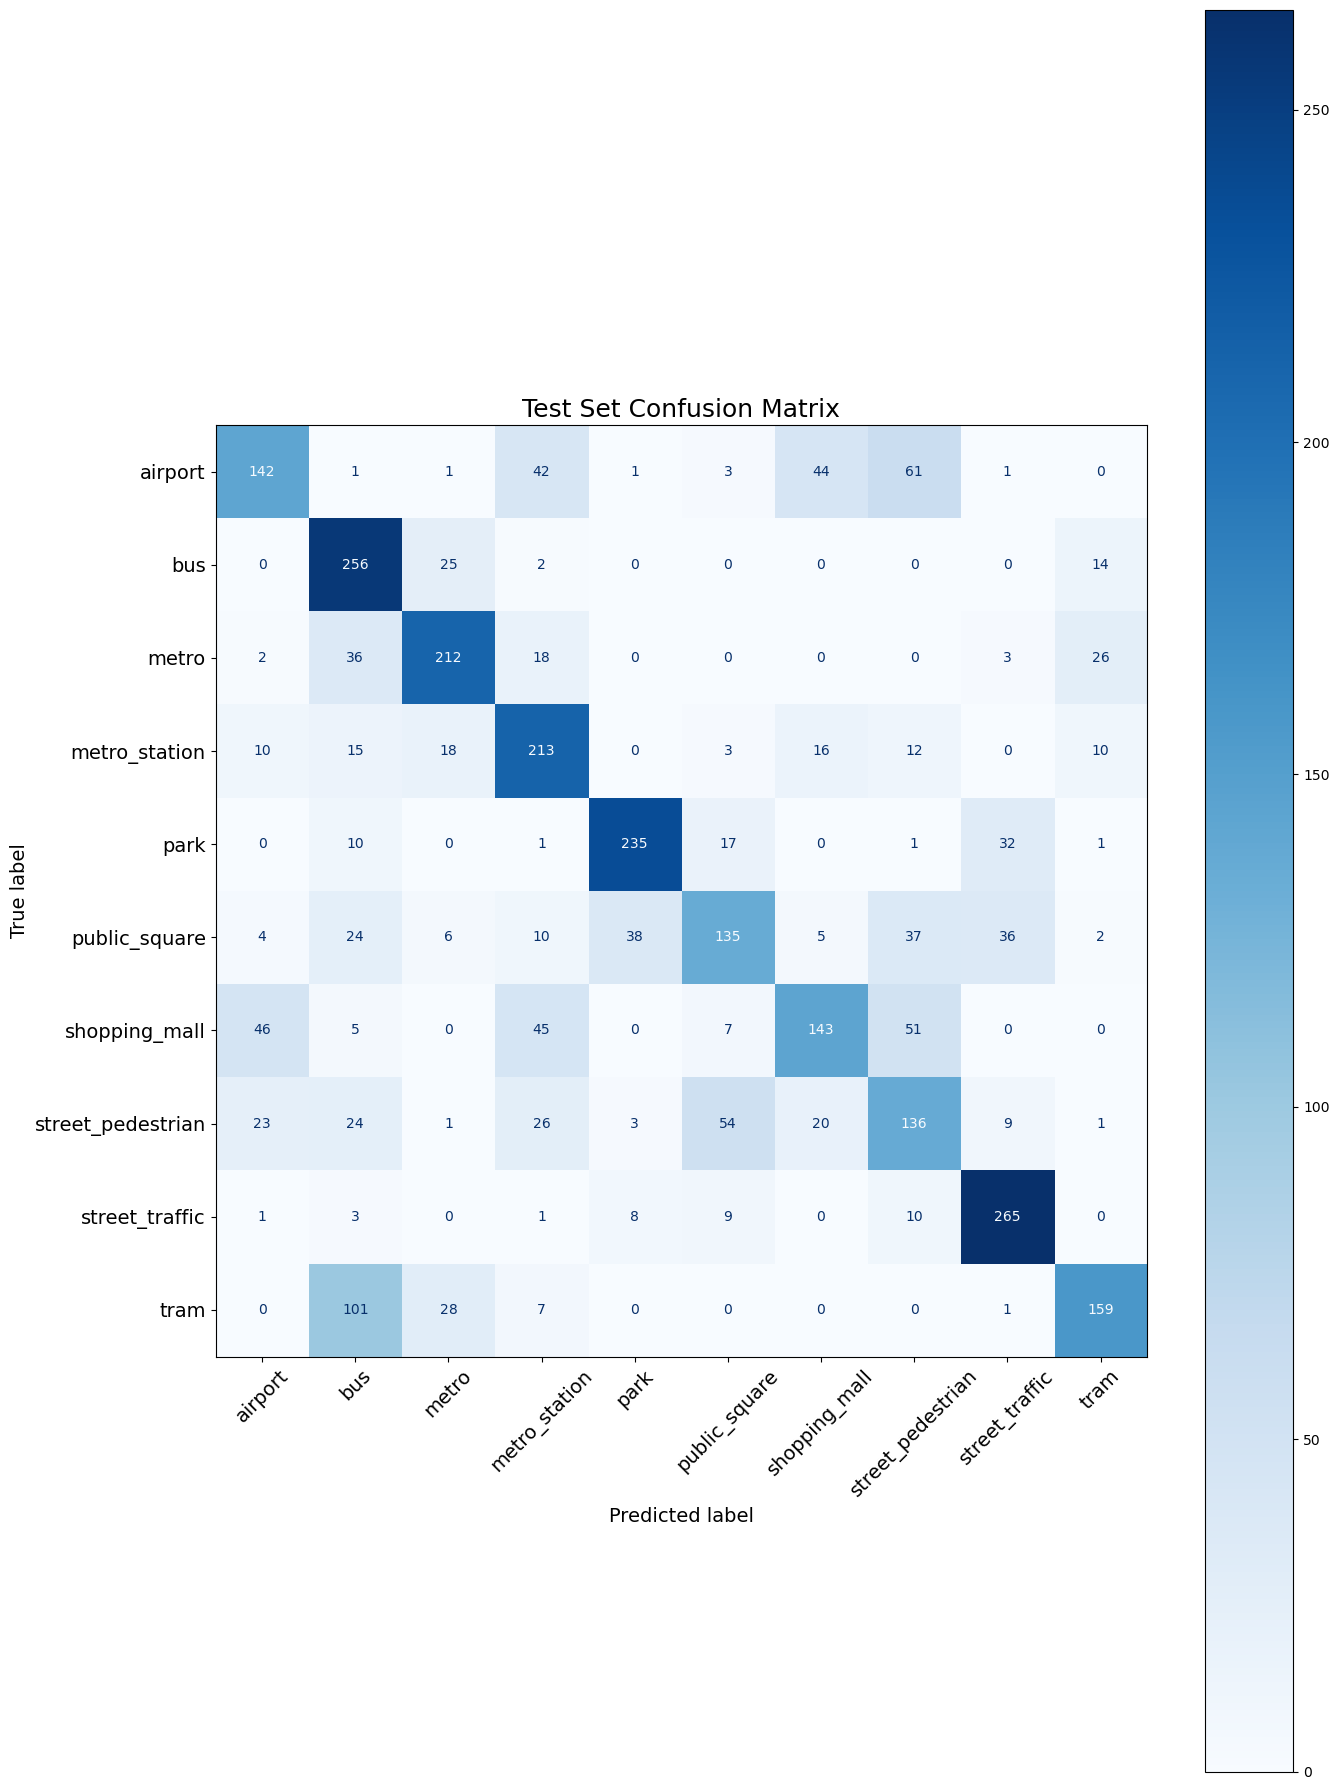

In [13]:
plot_confusion_matrix(F, C, test_loader, class_names, title="Test Set Confusion Matrix",figsize=(14,18))